In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/Shareddrives/Confidence Probes/taskdiscovery')
    !pip3 install transformer_lens fancy_einsum einops datasets encoders plotly circuitsvis

else:
    print("Not running in Google Colab, skipping installation of requirements.")


Not running in Google Colab, skipping installation of requirements.


In [2]:
from training_utils import load_model_data,plot_losses,LinePlot,show_token_preds
from lens import get_lens_loss
import torch
from tqdm import tqdm
import numpy as np
import pickle
import math


## Load model and data
We will be using gpt2 small for now.

In [3]:
model_name = "gpt2-small"
batch_size = 32
device, model, tokenizer, owt_iter = load_model_data(model_name, batch_size)
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_dim = model.cfg.d_head
d_model = model.cfg.d_model
lr = 1e-3

folder = "./results/"
shared_bias = False

print(n_layers, n_heads, head_dim, d_model)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (61422 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (58948 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (59558 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (71857 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to 

12 12 64 768


## Create Modal Lens Prameters

In [4]:
prior_bias = [model.blocks[i].attn.b_O.clone() for i in range(n_layers)]

attn_bias = [
    torch.nn.Parameter(
        (prior_bias[i] if shared_bias else prior_bias[i].repeat(i + 1, 1)).to(device)
    )
    for i in range(n_layers)
]

lens_optimizer = torch.optim.AdamW(attn_bias, lr=lr, weight_decay=0)

for param in model.parameters():
    param.requires_grad = False


## Training Loop

In [ ]:
lp = LinePlot([*[f"kl_loss_{k}" for k in range(n_layers)], "step_size"])

for i in tqdm(range(10000)):
    batch = next(owt_iter)["tokens"]
    lens_optimizer.zero_grad()

    kl_losses, _, _ = get_lens_loss(batch, model, n_layers, attn_bias,batch_size)
    kl_losses = kl_losses.mean(dim=-1)
    loss = torch.clamp(kl_losses.sum(), max=100)
    loss.backward()

    prev_weights = torch.cat(attn_bias, dim=0).detach()

    lens_optimizer.step()

    step_sz = (torch.cat(attn_bias, dim=0) - prev_weights).abs().sum()
    lp.add_entry(
        {
            "step_size": step_sz.item(),
            **{f"kl_loss_{k}": kl_losses[k].item() for k in range(n_layers)},
        }
    )

    # lens_scheduler.step()

    if math.isnan(lp.stat_book["step_size"][-1]):
        break

    if i % 1000 == 0:
        lp.plot(subplots=3, save=f"{folder}/train.png", twinx=False, mv=20)
        with open(f"{folder}/modal_lens_weights.pkl", "wb") as f:
            pickle.dump(attn_bias, f)

In [9]:
tuned_lens_folder = folder
with open(f"{folder}/modal_lens_weights.pkl", "rb") as f:
    attn_bias = pickle.load(f)


with open(f"{tuned_lens_folder}/tuned_lens_weights.pkl", "rb") as f:
    tuned_lens_weights = pickle.load(f)
with open(f"{tuned_lens_folder}/tuned_lens_bias.pkl", "rb") as f:
    tuned_lens_bias = pickle.load(f)

activations = []
all_losses = ([],[])

for i in tqdm(range(1000)):
    batch = next(owt_iter)['tokens']

    with torch.no_grad():
        kl_losses, tuned_lens_loss, activation_storage,_ = get_lens_loss(batch,
                                                                       model,
                                                                       n_layers,
                                                                       attn_bias,
                                                                       batch_size,
                                                                       tuned_lens_weights,
                                                                       tuned_lens_bias,
                                                                       compare_tuned_lens=True)
        all_losses[0].append(kl_losses)
        all_losses[1].append(tuned_lens_loss)
        activations.append(torch.stack(activation_storage))



100%|██████████| 1000/1000 [01:52<00:00,  8.90it/s]


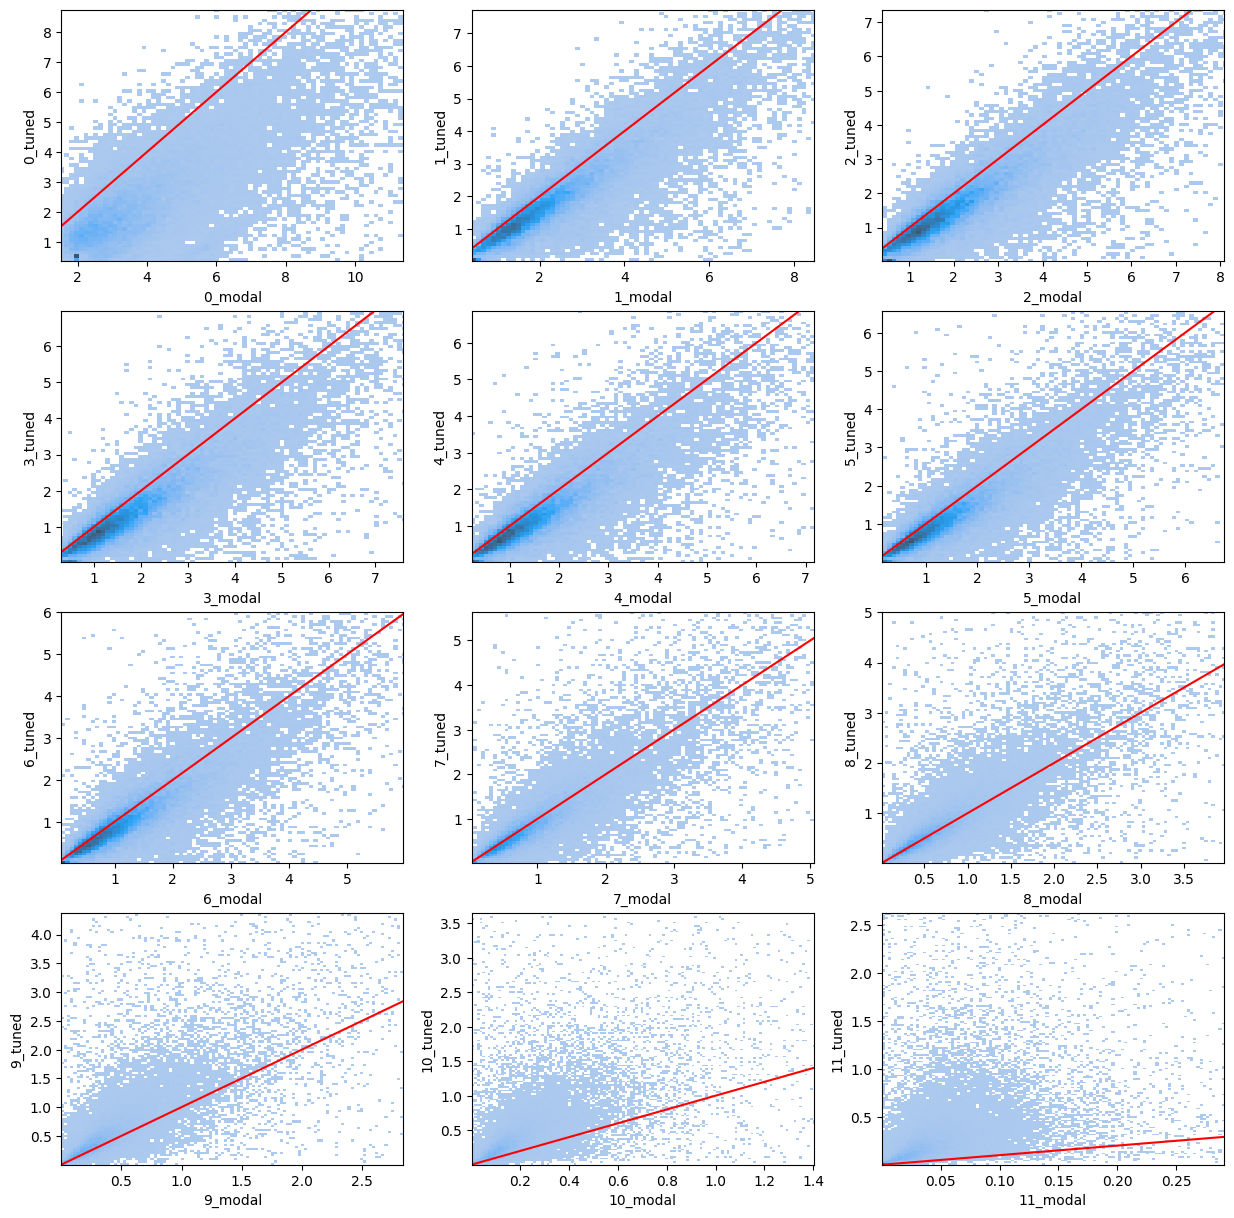

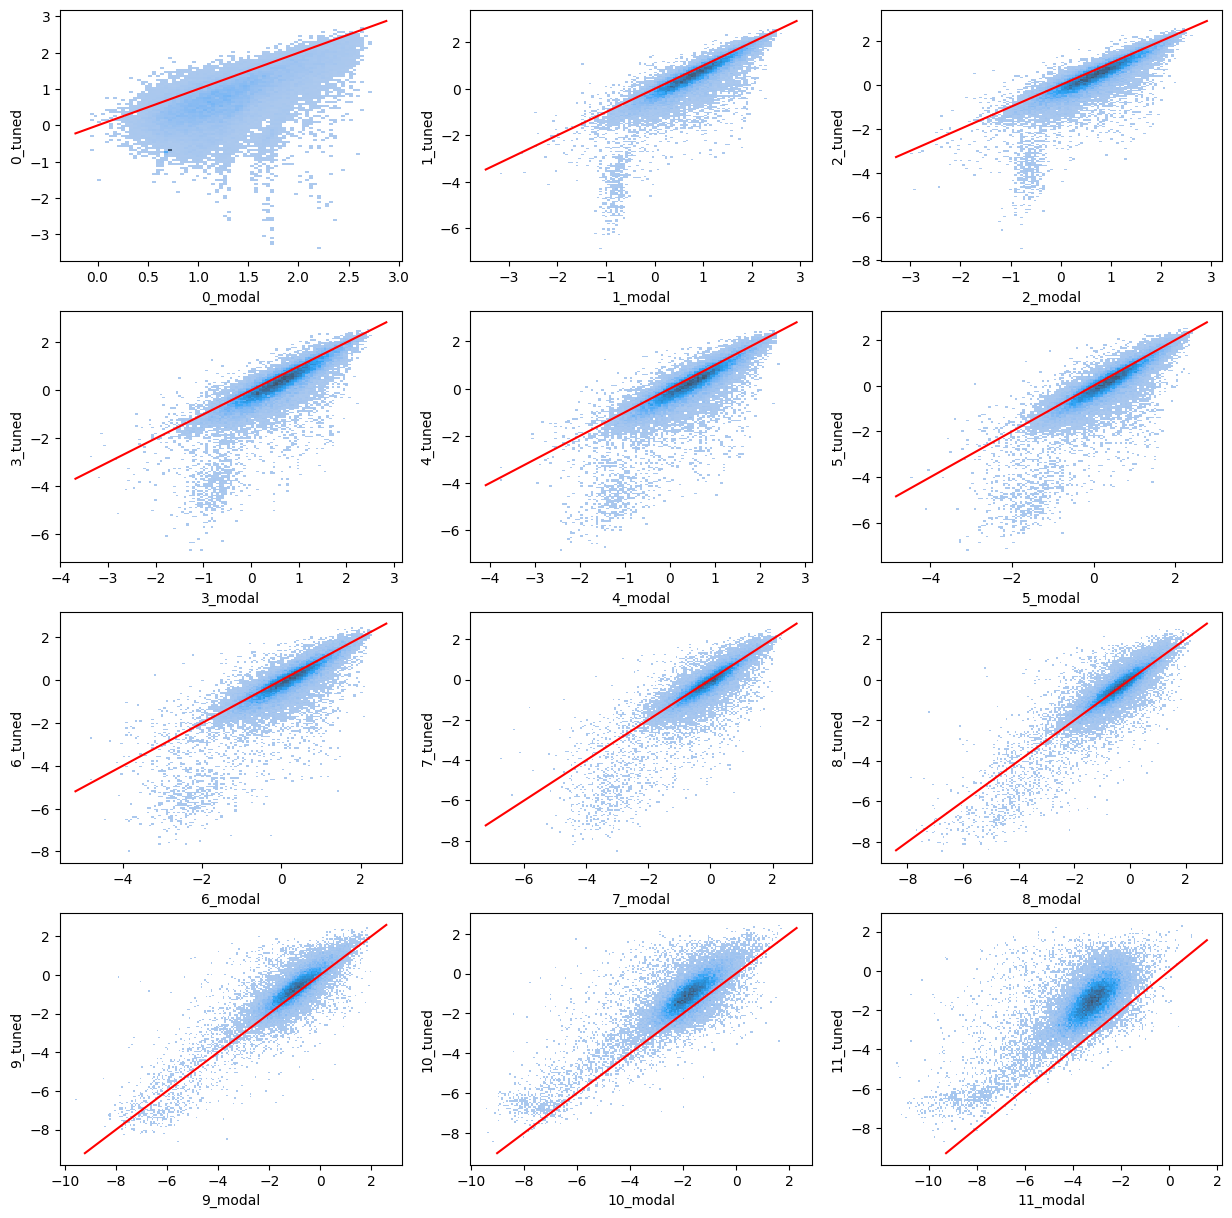

In [ ]:
plot_losses(torch.cat(all_losses[0], dim=1).cpu().numpy().T,
            torch.cat(all_losses[1], dim=1).cpu().numpy().T,
            n_layers = 12)

In [ ]:
sentence = "I need a lot of"

x = tokenizer(sentence, return_tensors="pt")["input_ids"]
with torch.no_grad():
     kl_losses, tuned_lens_loss, activation_storage,output_probs = get_lens_loss(batch,
                                                                      model,
                                                                      n_layers,
                                                                      attn_bias,
                                                                      batch_size,
                                                                      tuned_lens_weights,
                                                                      tuned_lens_bias,
                                                                      compare_tuned_lens=False)


show_token_preds(logits.softmax(-1), output[0], tokenizer, sentence)